# OSMOSIS Spring

This notebook runs [GOTM](https://gotm.net/) with initial conditions and surface forcing during the spring months (Dec. 25, 2012 - Sep. 10, 2013) of the Ocean Surface Mixing, Ocean Submesoscale Interaction Study in the northeast Atlantic (OSMOSIS, 48.7$^\circ$N, 16.2$^\circ$W; [Damerell et al., 2016](https://doi.org/10.1002/2015JC011423)). See Fig. 3 of [Li et al., 2019](https://doi.org/10.1029/2019MS001810).

In [1]:
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../../../gotmtool")
from gotmtool import *

## Create a model
Create a model with environment file `../../.gotm_env.yaml`, which is created by `gotm_env_init.py`. 

In [2]:
m = Model(name='OSMOSIS-Spring', environ='../../.gotm_env.yaml')

Take a look at what are defined in the environment file.

In [3]:
for key in m.environ:
    print('{:>15s}: {}'.format(key, m.environ[key]) )

   gotmdir_code: /Users/qingli/develop/dev_gotmtool/gotm/code
   gotmdir_data: /Users/qingli/develop/dev_gotmtool/gotm/data
  gotmdir_build: /Users/qingli/develop/dev_gotmtool/gotm/build
    gotmdir_exe: /Users/qingli/develop/dev_gotmtool/gotm/exe
    gotmdir_run: /Users/qingli/develop/dev_gotmtool/gotm/run
 gotmdir_figure: /Users/qingli/develop/dev_gotmtool/gotm/figure
   gotmdir_tool: /Users/qingli/develop/dev_gotmtool/gotmtool


## Build the model

In [4]:
%%time
m.build()

CPU times: user 823 µs, sys: 5.28 ms, total: 6.11 ms
Wall time: 65.1 ms


## Configuration
Initialize the GOTM configuration

In [5]:
cfg = m.init_config()

Generating default configuration at '/Users/qingli/develop/dev_gotmtool/gotm/run/OSMOSIS-Spring/gotm.yaml'...
Done!


Update the configuration

In [6]:
# setup
title = 'OSMOSIS - Spring'
nlev = 480
cfg['title'] = title
cfg['location']['name'] = 'OSMOSIS'
cfg['location']['latitude'] = 48.7
cfg['location']['longitude'] = -16.2
cfg['location']['depth'] = 480.0
cfg['time']['start'] = '2012-12-25 00:00:00'
cfg['time']['stop']  = '2013-09-10 03:00:00'
cfg['time']['dt']    = 600.0
cfg['grid']['nlev']  = nlev

# output
cfg['output']['gotm_out']['title'] = title
cfg['output']['gotm_out']['k1_stop'] = nlev+1
cfg['output']['gotm_out']['k_stop'] = nlev
cfg['output']['gotm_out']['time_unit'] = 'hour'
cfg['output']['gotm_out']['time_step'] = 3

# forcing
datadir = m.environ['gotmdir_data']+'/examples/OSMOSIS-Spring'
cfg['temperature']['method'] = 'file'
cfg['temperature']['file'] = datadir+'/t_prof.dat'
cfg['salinity']['method'] = 'file'
cfg['salinity']['file'] = datadir+'/s_prof.dat'
cfg['surface']['fluxes']['heat']['method'] = 'file'
cfg['surface']['fluxes']['heat']['file'] = datadir+'/heat_flux.dat'
cfg['surface']['fluxes']['tx']['method'] = 'file'
cfg['surface']['fluxes']['tx']['file'] = datadir+'/momentum_flux.dat'
cfg['surface']['fluxes']['tx']['column'] = 1
cfg['surface']['fluxes']['ty']['method'] = 'file'
cfg['surface']['fluxes']['ty']['file'] = datadir+'/momentum_flux.dat'
cfg['surface']['fluxes']['ty']['column'] = 2
cfg['surface']['swr']['method'] = 'file'
cfg['surface']['swr']['file'] = datadir+'/swr.dat'
cfg['surface']['precip']['method'] = 'file'
cfg['surface']['precip']['file'] = datadir+'/pme.dat'
cfg['waves']['stokes_drift']['us']['method'] = 'exponential'
cfg['waves']['stokes_drift']['vs']['method'] = 'exponential'
cfg['waves']['stokes_drift']['exponential']['us0']['method'] = 'file'
cfg['waves']['stokes_drift']['exponential']['us0']['file'] = datadir+'/stokes_drift.dat'
cfg['waves']['stokes_drift']['exponential']['us0']['column'] = 1
cfg['waves']['stokes_drift']['exponential']['vs0']['method'] = 'file'
cfg['waves']['stokes_drift']['exponential']['vs0']['file'] = datadir+'/stokes_drift.dat'
cfg['waves']['stokes_drift']['exponential']['vs0']['column'] = 2
cfg['waves']['stokes_drift']['exponential']['ds']['method'] = 'file'
cfg['waves']['stokes_drift']['exponential']['ds']['file'] = datadir+'/stokes_drift.dat'
cfg['waves']['stokes_drift']['exponential']['ds']['column'] = 3

# water type
cfg['light_extinction']['method'] = 'custom'
cfg['light_extinction']['A']['method'] = 'constant'
cfg['light_extinction']['A']['constant_value'] = 0.57
cfg['light_extinction']['g1']['method'] = 'constant'
cfg['light_extinction']['g1']['constant_value'] = 0.55
cfg['light_extinction']['g2']['method'] = 'constant'
cfg['light_extinction']['g2']['constant_value'] = 17.0

# EOS -- use linear
cfg['eq_state']['form'] = 'linear_custom'
cfg['eq_state']['linear']['T0'] = 10.0
cfg['eq_state']['linear']['S0'] = 35.0
cfg['eq_state']['linear']['dtr0'] = -0.17
cfg['eq_state']['linear']['dsr0'] = 0.78

# damping on velocity: relaxation to zero with a 5-day decay time
cfg['velocities']['relax']['tau'] = 432000.0

Set the turbulence method to the generic length scale (GLS; [Umlauf and Burchard, 2003](https://doi.org/10.1357/002224003322005087)) model in the $k$-$\epsilon$ formulation with the weak-equilibrium stability function by [Canuto et al., 2001](https://doi.org/10.1175/1520-0485(2001)031%3C1413:OTPIOP%3E2.0.CO;2) (C01A).

In [7]:
cfg['turbulence']['turb_method'] = 'second_order'
cfg['turbulence']['tke_method'] = 'tke'
cfg['turbulence']['len_scale_method'] = 'gls'
cfg['turbulence']['scnd']['method'] =  'weak_eq_kb_eq'
cfg['turbulence']['scnd']['scnd_coeff'] =  'canuto-a'
cfg['turbulence']['turb_param']['length_lim'] = 'false'
cfg['turbulence']['turb_param']['compute_c3'] = 'true'
cfg['turbulence']['turb_param']['Ri_st'] = 0.25
cfg['turbulence']['generic']['gen_m'] = 1.5 
cfg['turbulence']['generic']['gen_n'] = -1.0
cfg['turbulence']['generic']['gen_p'] = 3.0 
cfg['turbulence']['generic']['cpsi1'] = 1.44
cfg['turbulence']['generic']['cpsi2'] = 1.92
cfg['turbulence']['generic']['cpsi3minus'] = -0.63
cfg['turbulence']['generic']['cpsi3plus'] = 1.0 
cfg['turbulence']['generic']['sig_kpsi'] = 1.0 
cfg['turbulence']['generic']['sig_psi'] = 1.3

## Run the model

In [8]:
%%time
sim = m.run(config=cfg, label='SMC-C01A')

CPU times: user 24.9 ms, sys: 3 ms, total: 27.9 ms
Wall time: 2.74 s


## Results

Load the data into an `xarray.Dataset`.

In [9]:
data = sim.load_data()

Temperature

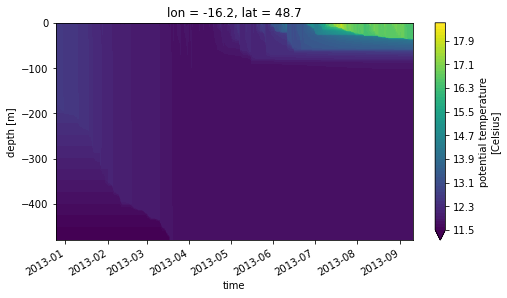

In [10]:
fig = plt.figure(figsize=[8,4])
levels = np.linspace(11.5, 18.5, 71)
data.temp.plot(levels=levels)

## Try different turbulence models

Now run the same model with [CVMix](http://cvmix.github.io). Try three options in CVMix:

- KPP-CVMix ([Large et al., 1994](https://doi.org/10.1029/94RG01872), [Griffies et al., 2015](https://github.com/CVMix/CVMix-description/raw/master/cvmix.pdf))
- KPPLT-VR12 ([Li et al., 2016](https://doi.org/10.1016%2Fj.ocemod.2015.07.020))
- KPPLT-LF17 ([Li and Fox-Kemper, 2017](https://doi.org/10.1175%2FJPO-D-17-0085.1))

In [11]:
cfgs = []
labels = []

In [12]:
cfg['turbulence']['turb_method'] = 'cvmix'
cfg['cvmix']['surface_layer']['kpp']['langmuir_method'] = 'none'
cfgs.append(copy.deepcopy(cfg))
labels.append('KPP-CVMix')

In [13]:
cfg['cvmix']['surface_layer']['kpp']['langmuir_method'] = 'lwf16'
cfgs.append(copy.deepcopy(cfg))
labels.append('KPPLT-VR12')

In [14]:
cfg['cvmix']['surface_layer']['kpp']['langmuir_method'] = 'lf17'
cfgs.append(copy.deepcopy(cfg))
labels.append('KPPLT-LF17')

Run the three cases in parallel with 3 processes 

In [15]:
%%time
sims = m.run_batch(configs=cfgs, labels=labels, nproc=3)

CPU times: user 8.68 ms, sys: 11.4 ms, total: 20.1 ms
Wall time: 9.31 s


Plot the temperature in `KPP-CVMix` and the differences from it in `KPPLT-VR12` and `KPPLT-LF17`

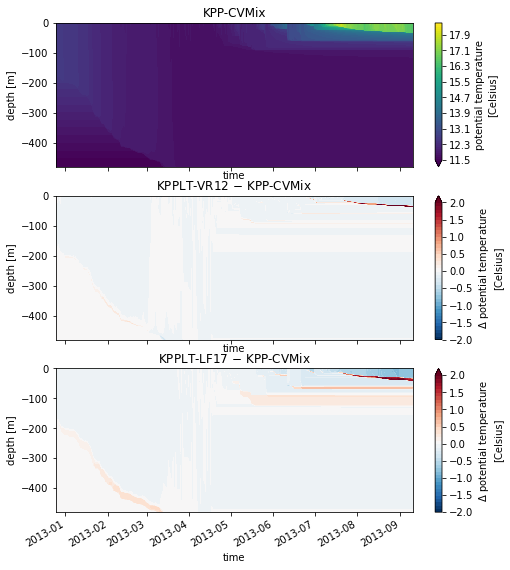

In [16]:
fig, axarr = plt.subplots(3, sharex='col')
fig.set_size_inches(8, 9)
data0 = sims[0].load_data()
levels = np.linspace(11.5, 18.5, 71)
data0.temp.plot(ax=axarr[0], levels=levels)
axarr[0].set_title(labels[0])
levels_diff = np.linspace(-2, 2, 41)
for i in np.arange(2):
    j = i+1
    diff = sims[j].load_data().temp - data0.temp
    diff.attrs['long_name'] = '$\Delta$ '+ data0.temp.attrs['long_name']
    diff.attrs['units'] = data0.temp.attrs['units']
    diff.plot(ax=axarr[j], levels=levels_diff)
    axarr[j].set_title(labels[j]+' $-$ '+labels[0])